In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
import pairtools
import pairtools.lib.headerops as phead

In [2]:
dpath = "/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct"
file_list = glob.glob(f"{dpath}/*")
file_list[:10]

['/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o1b74.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b83.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b89.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b03.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o2b63.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o3b13.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o3b34.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b93.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o2b04.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/s

In [3]:
def load_pairs(fpath, comment_char="#"):
    """Loads a pairs table from a tab-separated file.

    Args:
        fpath (str): The file path to the pairs table.
        comment_char (str, optional): The character indicating comment lines. 
                                     Defaults to "#".

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the pairs table data.
    """
    header = phead.get_header(open(fpath))[0][-1]
    header = header.replace("#columns: ", "")
    header = header.split(" ")
    
    df = pd.read_csv(fpath, 
                     sep='\t', 
                     header=None, 
                     names=header, 
                     comment="#")
    return df

In [4]:
result = []

columns = [
    'chrom1',
    'chrom2',
    'pos1',
    'pos2',
    'pair_type',
    
]

for i, file_path in enumerate(file_list):
    
    if i % 25 == 0:
        print(f"{i} of {len(file_list)}")
    
    basename = os.path.basename(file_path)
    cell_id = basename[2:5]
    sample_id = basename[:2]
    
    df = load_pairs(file_path)
    df = df[columns]

    # drop unamappable pairs
    df = df[df['pair_type'] == 'UU']
    
    # drop trans contacts
    df = df[df['chrom1'] == df['chrom2']]
    
    # compute distance
    df['distance'] = np.abs(df['pos1'] - df['pos2'])
    df['sample_id'] = sample_id
    df['cell_id'] = cell_id
    
    df = df.reset_index(drop=True)
    
    if not df.empty:
        result.append(df)
        

result = pd.concat(result)
print(f"{result.shape=}")
result.head()

0 of 380
25 of 380
50 of 380
75 of 380
100 of 380
125 of 380
150 of 380
175 of 380
200 of 380
225 of 380
250 of 380
275 of 380
300 of 380
325 of 380
350 of 380
375 of 380
result.shape=(427756, 8)


,chrom1,chrom2,pos1,pos2,pair_type,distance,sample_id,cell_id
0,1,1,174177035,174175969,UU,1066,o1,b74
1,9,9,68487421,68486321,UU,1100,o1,b74
2,3,3,25749643,25750787,UU,1144,o1,b74
3,17,17,73248806,73247788,UU,1018,o1,b74
4,16,16,10328888,10330276,UU,1388,o1,b74


Text(0.5, 0, 'Contact Distance')

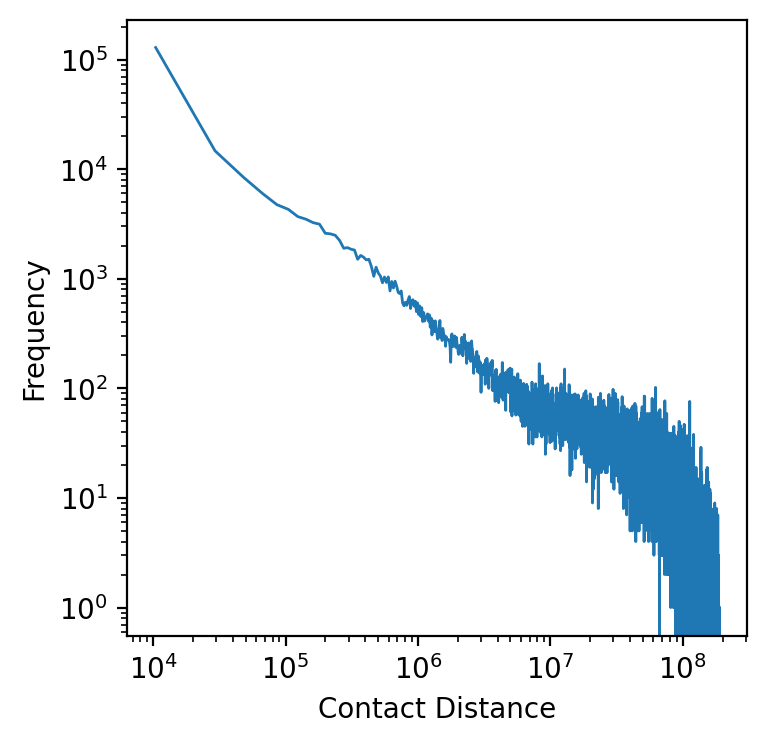

In [47]:
sns.histplot(
    result, 
    x='distance',
    bins=10000,
    element='poly',
    stat='count',
    fill=False,
    lw=1,
)

plt.xscale('log')
plt.yscale('log')

plt.ylabel('Frequency')
plt.xlabel('Contact Distance')

In [115]:
groups = 100000
result['D'] = pd.cut(result['distance'], bins=groups)
pdf = result['D'].value_counts(normalize=True)
pdf = pdf.reset_index()

pdf['x'] = pdf['D'].apply(lambda x: max(0, x.mid))

pdf.head(10)

,D,proportion,x
0,"(-188059.55, 2890.596]",0.170188,0.0000
1,"(2890.596, 4781.191]",0.042508,3835.8935
2,"(4781.191, 6671.786]",0.023312,5726.4885
3,"(6671.786, 8562.382]",0.016231,7617.0840
4,"(8562.382, 10452.977]",0.012484,9507.6795
5,"(10452.977, 12343.573]",0.010048,11398.2750
6,"(12343.573, 14234.168]",0.007839,13288.8705
7,"(14234.168, 16124.764]",0.006674,15179.4660
8,"(16124.764, 18015.36]",0.006160,17070.0620
9,"(18015.36, 19905.955]",0.005335,18960.6575


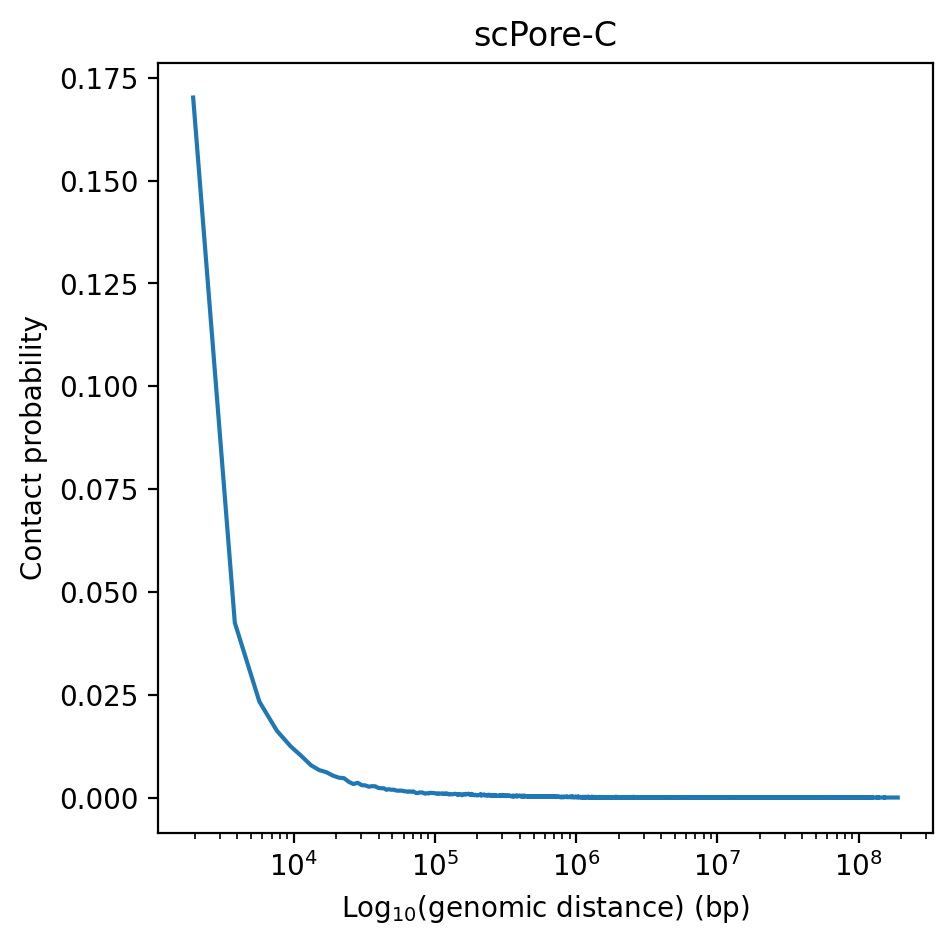

In [85]:
def plot_ps_curve(distances, num_bins=30):
    """
    Calculates and plots the P(s) curve (contact probability vs. genomic separation)
    from an array of pairwise genomic distances.

    Args:
        distances: A numpy array of pairwise genomic distances.
        num_bins: The number of logarithmic bins to use for the histogram.
                  (Default: 30)
    """

    # Calculate log-spaced bins for a wide range of distances
    bins = np.linspace(min(distances), max(distances), num_bins)

    # Count the number of distances falling into each bin
    counts, _ = np.histogram(distances, bins)

    # Normalize counts to probabilities
    probabilities = counts / np.sum(counts)

    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create the plot
    plt.figure(figsize=(5, 5))
    plt.plot(bin_centers, probabilities, '-')  # Log-log plot is common
    plt.xlabel('Log$_{10}$(genomic distance) (bp)')
    plt.ylabel('Contact probability')
    plt.xscale('log')
    plt.title('scPore-C')
    plt.show()
    
    
plot_ps_curve(result['distance'].values, num_bins=100000)


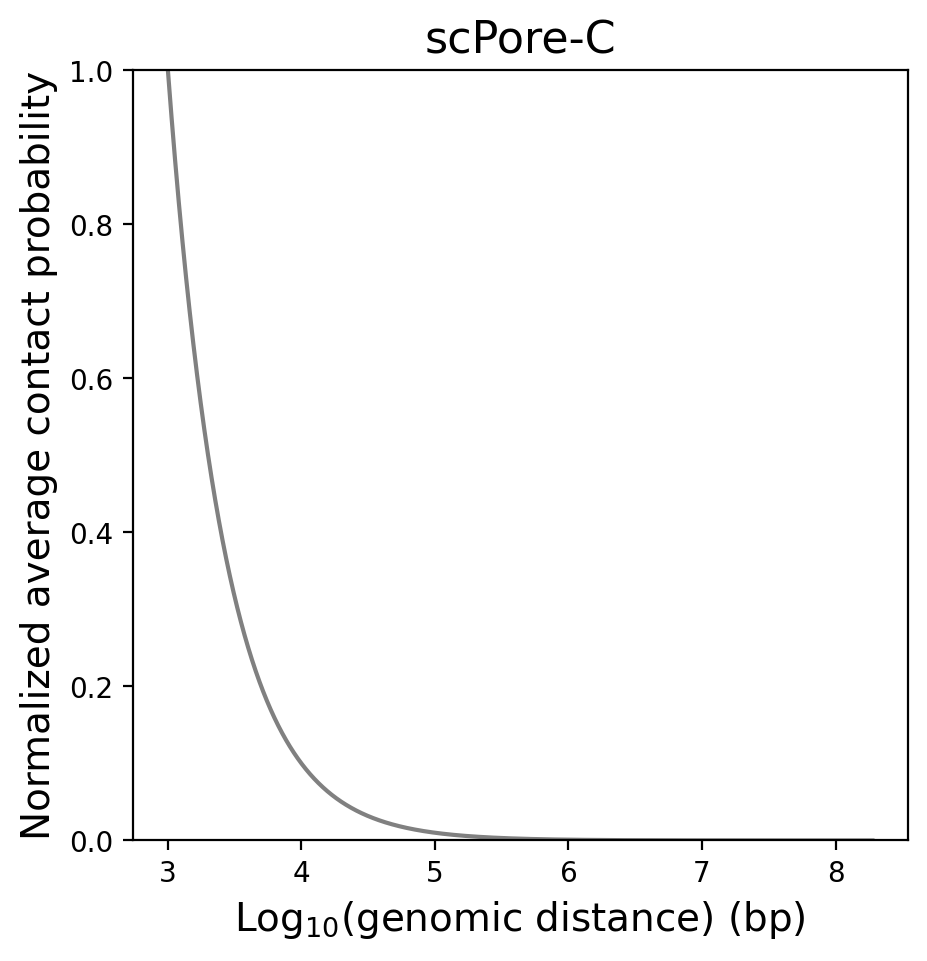

In [67]:
def plot_contact_probability(distances):
    """
    Creates a plot of normalized average contact probability (between 0 and 1) 
    vs. log10(genomic distance), given a vector of observed distances.

    Args:
        distances: A numpy array or list of genomic distances in base pairs.
    """

    # Create DataFrame
    data = pd.DataFrame({'distance': distances})

    # Calculate probabilities (example relationship, adjust if needed)
    data['probability'] = 1 / data['distance']

    # Group and calculate mean probability
    data = data.groupby('distance')['probability'].mean().reset_index()

    # Normalize probabilities to be between 0 and 1
    min_prob = data['probability'].min()
    max_prob = data['probability'].max()
    data['probability'] = (data['probability'] - min_prob) / (max_prob - min_prob)

    # Plotting
    plt.figure(figsize=(5, 5))
    plt.plot(
        np.log10(data['distance']),
        data['probability'],
        linestyle='-',
        lw=1.5,
        color='gray',
    )
    plt.xlabel('Log$_{10}$(genomic distance) (bp)', fontsize=14)
    plt.ylabel('Normalized average contact probability', fontsize=14)
    plt.title('scPore-C', fontsize=16)
    plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
    plt.show()
    
    
plot_contact_probability(result['distance'].values)

In [ ]:
break

Text(0.5, 0, 'Contact Distance')

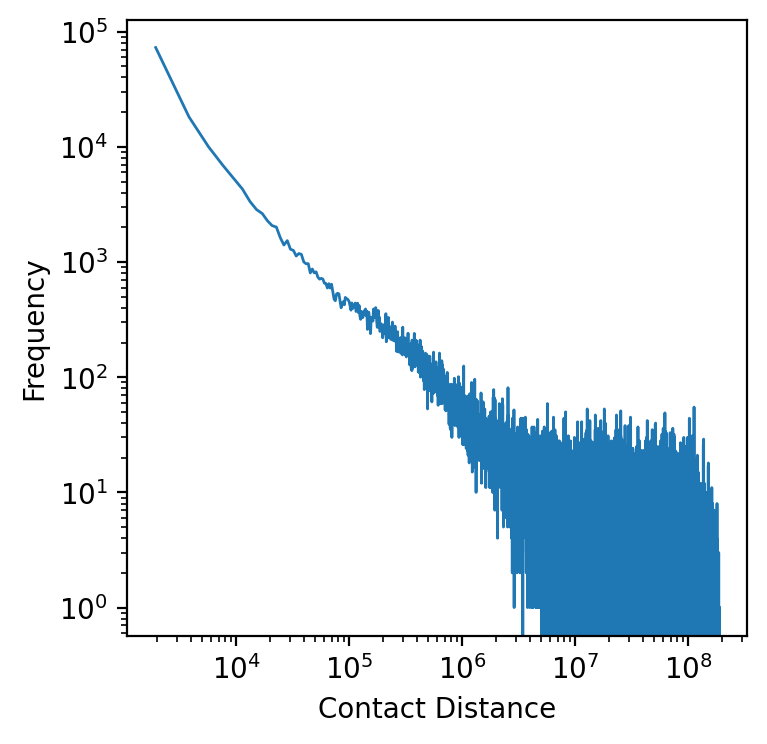

In [66]:
bins = 100000
counts, bin_edges = np.histogram(result['distance'].values, bins=bins)

# Get bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Plot KDE smoothed line
plt.plot(bin_centers, counts, lw=1)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('Frequency')
plt.xlabel('Contact Distance')

In [20]:
bin_edges

array([1.00000000e+03, 1.18905936e+03, 1.37811872e+03, ...,
       1.89060172e+08, 1.89060361e+08, 1.89060550e+08])

In [ ]:
break

In [ ]:
# Data preparation (same as before)
bins = 1000001
counts, bin_edges = np.histogram(result['distance'].values, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
valid_indices = counts > 0
bin_centers_valid = bin_centers[valid_indices]
counts_valid = counts[valid_indices]

# Function to fit (cubic polynomial on log-transformed data)
def cubic_poly(x, a, b, c, d):
    return 10**(a*x**3 + b*x**2 + c*x + d)

# Curve fitting
popt, pcov = curve_fit(cubic_poly, np.log10(bin_centers_valid), np.log10(counts_valid), maxfev=1000)

# Generate fitted line
fit_curve = cubic_poly(np.log10(bin_centers_valid), *popt)

# Plotting
plt.figure(dpi=200, figsize=(4, 4))
plt.loglog(bin_centers_valid, counts_valid, 'o', markersize=2, label='Data')
plt.loglog(bin_centers_valid, fit_curve, '-', label='Cubic Fit')

plt.xlabel('Contact Distance')
plt.ylabel('Frequency')
plt.title('Frequency vs. Contact Distance (Log-Log Scale)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

print("Fitted parameters:", popt)

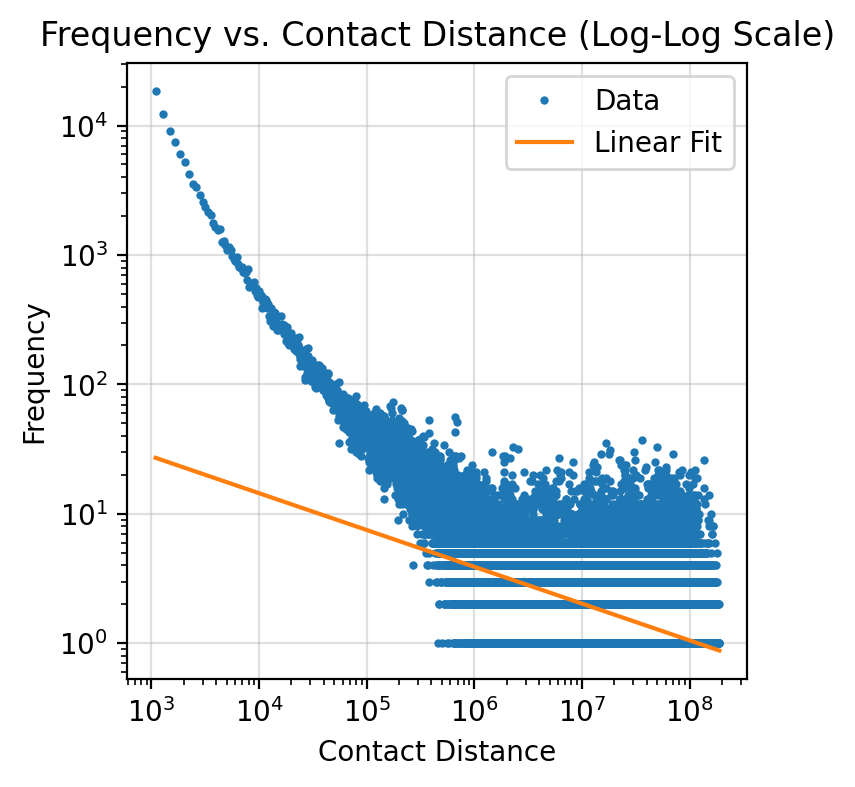

In [14]:
from scipy.stats import linregress

bins = 1000001
counts, bin_edges = np.histogram(result['distance'].values, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Filter out zero counts to avoid issues with log scaling
valid_indices = counts > 0
bin_centers_valid = bin_centers[valid_indices]
counts_valid = counts[valid_indices]

# Linear Regression on Log-Transformed Data
slope, intercept, r_value, p_value, std_err = linregress(np.log10(bin_centers_valid), np.log10(counts_valid))

# Create Fit Line
fit_line = 10**(intercept + slope * np.log10(bin_centers_valid))

# Plotting
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

plt.loglog(bin_centers_valid, counts_valid, 'o', markersize=2, label='Data')
plt.loglog(bin_centers_valid, fit_line, '-', label='Linear Fit')

plt.xlabel('Contact Distance')
plt.ylabel('Frequency')
plt.title('Frequency vs. Contact Distance (Log-Log Scale)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
for sample, group in result.groupby('sample_id'):
    bins = 101
    counts, bin_edges = np.histogram(group['distance'].values, bins=bins)

    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 4

    # Plot line plot of counts
    plt.plot(bin_centers, counts, label=sample)

    plt.yscale('log')
    plt.xscale('log')

    # plt.title(f"Sample {sample}")
    plt.ylabel('Frequency')
    plt.xlabel('Contact Distance')
    
plt.legend()

# For all direct contacts (unfiltered)

In [ ]:
dpath = "/scratch/indikar_root/indikar1/shared_data/single_cell/pairs/"
file_list = glob.glob(f"{dpath}/*direct*")
file_list[:10]

In [ ]:
result = []

columns = [
    'chrom1',
    'chrom2',
    'pos1',
    'pos2',
    'pair_type',
    
]

for i, file_path in enumerate(file_list):
    
    if i % 25 == 0:
        print(f"{i} of {len(file_list)}")
    
    basename = os.path.basename(file_path)
    cell_id = basename[2:5]
    sample_id = basename[:2]
    
    df = load_pairs(file_path)
    df = df[columns]

    # drop unamappable pairs
    df = df[df['pair_type'] == 'UU']
    
    # drop trans contacts
    df = df[df['chrom1'] == df['chrom2']]
    
    # compute distance
    df['distance'] = np.abs(df['pos1'] - df['pos2'])
    df['sample_id'] = sample_id
    df['cell_id'] = cell_id
    
    df = df.reset_index(drop=True)
    
    if not df.empty:
        result.append(df)
        

result = pd.concat(result)
print(f"{result.shape=}")
result.head()

In [ ]:
bins = 101
counts, bin_edges = np.histogram(result['distance'].values, bins=bins)

# Get bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Plot line plot of counts
plt.plot(bin_centers, counts)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('Frequency')
plt.xlabel('Contact Distance')